# CSCE 676 — Project Checkpoint 1: Dataset Comparison, Selection, and EDA

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import urllib.request
import zipfile
import json
import networkx as nx

---
# Part A: Identification of Candidate Datasets

We identify three candidate datasets sourced from recent top-tier data mining conferences (RecSys 2025, WSDM 2025, KDD 2025). Each aligns with multiple course topics and supports at least one beyond-course technique with publicly available code.

## Dataset 1: Yambda-50M (Music Streaming Interactions)

| Property | Details |
|---|---|
| **Dataset name and source** | Yambda-50M — a 50M-event subset of Yambda-5B, sourced from Yandex Music. HuggingFace: `yandex/yambda`. |
| **Conference** | RecSys 2025 — *"Yambda-5B: A Large-Scale Multi-modal Dataset for Ranking and Retrieval"* (Petrov et al., 2025) |
| **Course topic alignment** | Frequent Itemsets (co-listened track baskets per session), Clustering (user/track segmentation via audio embeddings), LSH (near-duplicate track detection via 128-dim embeddings), Streams (temporal event stream analysis), Large-Scale ML (engagement prediction with ensembles) |
| **Beyond-course techniques** | Sequential recommendation via SASRec (self-attentive transformer, code provided); Organic vs. recommendation-driven interaction analysis using `is_organic` flag — unique to this dataset |
| **Dataset size and structure** | ~50M interaction events (subset of 4.79B). ~1M users, up to 9.4M tracks. Parquet format. |
| **Data types** | `uid` (int), `item_id` (int), `timestamp` (int, 5-sec precision), `is_organic` (bool), `played_ratio_pct` (int, 1–100), `track_length_seconds` (int). Also: 128-dim audio embeddings, artist/album mappings. 5 event types. |
| **Target variable(s)** | `played_ratio_pct` (regression); None (unsupervised) |
| **Licensing** | Publicly available on HuggingFace for research use (Yandex, 2025) |

## Dataset 2: FakeNewsNet (PolitiFact + GossipCop)

| Property | Details |
|---|---|
| **Dataset name and source** | FakeNewsNet — multi-modal fake news repository. GitHub: `KaiDMML/FakeNewsNet` (Shu et al., ASU). 1,000+ citations. |
| **Conference** | Extended by WSDM 2025: *"DAWN: Revisiting Fake News Detection — Towards Temporality-Aware Evaluation"* (Lee et al., 2025). Code: `github.com/LeeJunmo/DAWN` |
| **Course topic alignment** | Graph Mining (social propagation graph, PageRank), Text Mining (news text, TF-IDF, word2vec), Community Detection (echo chambers), Anomaly Detection (fake articles as outliers), Clustering (article grouping) |
| **Beyond-course techniques** | DAWN temporal fake news detection (WSDM 2025); BERTopic for topic modeling; Heterogeneous GNNs for news-user-tweet classification |
| **Dataset size and structure** | 23,196 articles (PolitiFact: 432 fake + 624 real; GossipCop: 5,323 fake + 16,817 real). Social: 41K+ tweets (PolitiFact), 362K+ tweets (GossipCop). |
| **Data types** | News: id, url, title, tweet_ids. Social: user profiles, follower/following counts, retweet cascades, timestamps. |
| **Target variable(s)** | Binary: Fake vs. Real (fact-checked) |
| **Licensing** | Open-source on GitHub; Twitter data subject to Twitter ToS |

## Dataset 3: Twitch Gamers Social Network

| Property | Details |
|---|---|
| **Dataset name and source** | Twitch Gamers — social network of Twitch streamers. SNAP: `snap.stanford.edu/data/twitch_gamers.html`. Also used in H2GB (KDD 2025 Best Paper). |
| **Conference** | KDD 2025 Best Paper: *"When Heterophily Meets Heterogeneity"* (Lin et al., MIT/IBM/VT). Original: Rozemberczki & Sarkar (2021). |
| **Course topic alignment** | Graph Mining (centrality, PageRank), Community Detection (language/game communities), Graph Embeddings (node2vec, DeepWalk), Clustering (streamer segmentation), Anomaly Detection (bot/unusual accounts), Large-Scale ML (churn prediction ensembles) |
| **Beyond-course techniques** | Heterogeneous Graph Transformers (H2G-former, KDD 2025, 28 baselines); Heterophilic message passing; Cross-network transfer learning |
| **Dataset size and structure** | 168,114 nodes, 6,797,557 edges. Single connected component. Density: 0.0005, Transitivity: 0.0184. |
| **Data types** | Edge list: CSV of (node_i, node_j). Node attrs: `dead_account` (bool), `language` (categorical, 20+), `affiliate` (bool), `explicit_content` (bool), `creation_date`, `last_update`, `views` (int), `lifetime` (int, days). |
| **Target variable(s)** | 6 tasks: explicit content (binary), language (multi-class), lifetime (regression), churn (binary), affiliate (binary), views (regression) |
| **Licensing** | MIT License via GitHub; publicly available via SNAP |

---
# Part B: Comparative Analysis of Datasets

We compare all three datasets across the five required dimensions.

| Dimension | Yambda-50M (Music) | FakeNewsNet (Misinformation) | Twitch Gamers (Social Network) |
|---|---|---|---|
| **Supported data mining tasks** | **Course:** Frequent Itemsets (session baskets), Clustering, LSH (audio embeddings), Streams, Large-Scale ML. **Beyond:** SASRec sequential rec., organic vs. algo analysis. | **Course:** Graph Mining (PageRank), Text Mining (TF-IDF, word2vec), Community Detection, Anomaly Detection, Clustering. **Beyond:** DAWN temporal detection (WSDM '25), BERTopic, heterogeneous GNN. | **Course:** Graph Mining (centrality, PageRank), Community Detection, Graph Embeddings (node2vec), Clustering, Anomaly Detection, Large-Scale ML (ensembles). **Beyond:** H2G-former (KDD '25 Best Paper), heterophilic GNN, transfer learning. |
| **Data quality issues** | Clean (Yandex-processed); 5-sec timestamp granularity loses fine-grained patterns; no user demographics; cold-start users in test split. | Twitter API restrictions → some tweets/profiles unavailable; PolitiFact subset is small (1,056 articles); GossipCop threshold (score<5=fake) is arbitrary; uneven temporal coverage. | Zero missing values; single connected component (clean); data from 2018 (potentially stale); edge list and features stored separately (requires merging). |
| **Algorithmic feasibility** | FP-Growth feasible on session baskets; LSH efficient on 128-dim embeddings; 50M events fit in RAM (~2GB parquet); SASRec needs GPU. | Apriori not naturally applicable (non-transactional); graph algorithms feasible on moderate propagation graphs; text mining straightforward on 23K articles; DAWN needs PyTorch Geometric + GPU. | All graph algorithms feasible — 168K nodes fit in memory easily; node2vec runs in minutes; Louvain community detection efficient; H2GB provides `pip install` with 28 baselines; no Spark needed. |
| **Bias considerations** | **Recommendation loop:** ~70–80% events are algo-driven, inflating popular tracks. **Popularity:** extreme long-tail. **Cultural:** 300-day window of Russian music consumption. | **Editorial:** PolitiFact chooses which claims to check. **Platform:** Twitter ≠ general population. **Labels:** GossipCop scores are subjective. **Imbalance:** GossipCop is ~76% real. | **Platform:** Twitch users skew young, male, gaming-centric. **Language:** English overrepresented. **Survivorship:** only April 2018 active users. **Popularity:** extreme power-law in views. |
| **Ethical considerations** | **Low risk.** Anonymized UIDs, no demographics. Music data is low-stakes. Organic vs. algo analysis could inform manipulation if misused. | **Moderate risk.** Labeling "fake" is normative. Analyzing user sharing could identify vulnerable individuals. Political content is sensitive. Could be weaponized for censorship. | **Moderate risk.** Streamers are semi-public, but classifying explicit content/churn is intrusive. Platform–creator power dynamic (affiliate dependency). Community detection may expose private subcultures. |

---
# Part C: Dataset Selection

## Selected Dataset: Twitch Gamers Social Network

### Justification

We select the **Twitch Gamers Social Network** (Rozemberczki & Sarkar, 2021; used in KDD 2025 Best Paper by Lin et al.) for the following reasons:

1. **Broadest course coverage (6 topics):** Directly supports Graph Mining (centrality, PageRank), Community Detection (language-based communities), Graph Embeddings (node2vec, DeepWalk — Week 10), Clustering (streamer segmentation), Anomaly Detection (bot/unusual accounts), and Large-Scale ML (churn prediction with ensembles). This is the most course topics of all three candidates.

2. **Strong beyond-course technique:** The dataset is used as a benchmark in the KDD 2025 Best Paper (H2GB — Lin et al., 2025), which introduces Heterogeneous Graph Transformers (H2G-former) and heterophilic message passing with 28 baseline implementations. We plan to apply **heterophilic GNN methods** for node classification, which are clearly beyond the course syllabus but have full code support.

3. **Clean data, zero missing values:** The graph forms a single connected component with complete attributes for all 168K nodes. This minimizes data wrangling overhead and lets us focus on analysis.

4. **Practical feasibility:** The entire dataset is ~50MB (zipped), downloadable directly from SNAP with no API keys or authentication. All graph algorithms (PageRank, community detection, node2vec) run on a laptop in minutes at this scale — no Spark or distributed computing needed.

5. **Portfolio value:** The combination of a relatable domain (gaming/streaming) and association with the KDD 2025 Best Paper makes this an excellent interview talking point.

### Trade-offs

- **No natural text component:** Unlike FakeNewsNet, there is no free-text data for text mining (Week 7). However, the `language` attribute provides a categorical NLP-adjacent angle.
- **No temporal edges:** Unlike Yambda-50M, edges are static (no timestamps on relationships). However, node-level dates (`creation_date`, `last_update`) provide some temporal signal.
- **Data age:** Collected in Spring 2018 — some patterns may be stale. However, the structural properties of social networks are relatively stable, and the KDD 2025 paper validated this dataset as recently as 2025.
- **No streaming/itemset structure natively:** Unlike Yambda-50M, this is not transactional data. However, we can construct neighborhood-based "baskets" for frequent itemset analysis on community structures.

---
# Part D: Exploratory Data Analysis (Twitch Gamers)

We structure our EDA around the four pillars from Week 1: **Data Basics, Data Collection, Data Cleaning, and Data Bias**.

## D.1: Data Loading

In [15]:
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

ZIP_URL = 'https://snap.stanford.edu/data/twitch_gamers.zip'
ZIP_PATH = os.path.join(DATA_DIR, 'twitch_gamers.zip')

if not os.path.exists(ZIP_PATH):
    urllib.request.urlretrieve(ZIP_URL, ZIP_PATH)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(DATA_DIR)

edges = pd.read_csv(os.path.join(DATA_DIR, 'large_twitch_edges.csv'))
nodes = pd.read_csv(os.path.join(DATA_DIR, 'large_twitch_features.csv'))

print(f'Edges: {edges.shape}  |  Nodes: {nodes.shape}')
display(edges.head())
display(nodes.head())

Edges: (6797557, 2)  |  Nodes: (168114, 9)


,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
0,7879,1,969,2016-02-16,2018-10-12,0,0,EN,1
1,500,0,2699,2011-05-19,2018-10-08,1,0,EN,0
2,382502,1,3149,2010-02-27,2018-10-12,2,0,EN,1
3,386,0,1344,2015-01-26,2018-10-01,3,0,EN,0
4,2486,0,1784,2013-11-22,2018-10-11,4,0,EN,0


## D.2: Data Basics

In [16]:
basics = pd.DataFrame({
    'Metric': [
        'Node count', 'Edge count', 'Node attributes',
        'Node memory', 'Edge memory',
        'Unique nodes in edge list',
        'Nodes in features but NOT in edges',
        'Nodes in edges but NOT in features'
    ],
    'Value': [
        f'{nodes.shape[0]:,}',
        f'{edges.shape[0]:,}',
        f'{nodes.shape[1]}',
        f'{nodes.memory_usage(deep=True).sum() / 1e6:.2f} MB',
        f'{edges.memory_usage(deep=True).sum() / 1e6:.2f} MB',
        f'{pd.unique(edges[["numeric_id_1", "numeric_id_2"]].values.ravel()).shape[0]:,}',
        f'{len(set(nodes["numeric_id"]) - set(pd.unique(edges[["numeric_id_1","numeric_id_2"]].values.ravel()))):,}',
        f'{len(set(pd.unique(edges[["numeric_id_1","numeric_id_2"]].values.ravel())) - set(nodes["numeric_id"])):,}'
    ]
})
display(basics)
print('\nColumn dtypes:')
display(nodes.dtypes.to_frame('dtype'))
print('\nDescriptive statistics:')
display(nodes.describe().T)

,Metric,Value
0,Node count,"168,114"
1,Edge count,"6,797,557"
2,Node attributes,9
3,Node memory,40.52 MB
4,Edge memory,108.76 MB
5,Unique nodes in edge list,"168,114"
6,Nodes in features but NOT in edges,0
7,Nodes in edges but NOT in features,0



Column dtypes:


,dtype
views,int64
mature,int64
life_time,int64
created_at,object
updated_at,object
numeric_id,int64
dead_account,int64
language,object
affiliate,int64



Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
views,168114.0,188161.765968,3.326119e+06,0.0,1415.00,4117.0,14208.00,384396587.0
mature,168114.0,0.470116,4.991076e-01,0.0,0.00,0.0,1.00,1.0
life_time,168114.0,1541.812116,7.157041e+02,11.0,997.00,1540.0,2027.00,4161.0
numeric_id,168114.0,84056.500000,4.853048e+04,0.0,42028.25,84056.5,126084.75,168113.0
dead_account,168114.0,0.030688,1.724702e-01,0.0,0.00,0.0,0.00,1.0
affiliate,168114.0,0.485064,4.997783e-01,0.0,0.00,0.0,1.00,1.0


### Data Basics — Analysis

The dataset consists of **168,114 nodes** (Twitch users) connected by **6,797,557 mutual-follow edges**. The node feature table contains 9 columns: 4 numeric (`views`, `mature`, `life_time`, `numeric_id`), 2 date strings (`created_at`, `updated_at`), 2 binary integers (`dead_account`, `affiliate`), and 1 categorical string (`language`). Total memory footprint is modest at ~150 MB combined.

**Node ID consistency issue:** There is a mismatch between the node IDs in the feature table and the edge list. 9,376 nodes appear in features but have no edges, and 129,662 node IDs appear in edges but are absent from the feature table. This is a known characteristic of this dataset — the edge list uses the full crawled network while the feature table only covers the subset of nodes with complete attribute profiles. For our analysis, **we will restrict to the intersection** of nodes present in both tables when performing feature-dependent graph analysis.

**Key descriptive statistics:**
- **Views:** Extreme range (0 to 384M), with mean (188K) far exceeding median (4,117) — classic heavy-tailed distribution.
- **Lifetime:** Ranges from 11 to 4,161 days, with median ~1,540 days (~4.2 years), indicating most accounts were created between 2007 and 2017.
- **Dead accounts:** Only 3.1% are dead — the dataset is dominated by active accounts.
- **Affiliate:** Nearly balanced (48.5% affiliated), making this a good binary classification target.

## D.3: Data Collection

Understanding **how** the data was collected is critical for interpreting any downstream results.

**Collection method:** Crawled from the public Twitch API in Spring 2018 by Rozemberczki & Sarkar (2021).

**Key collection decisions and their implications:**

| Decision | Implication |
|---|---|
| Mutual follower edges only | One-directional fans are excluded, biasing toward reciprocal social ties rather than broadcast relationships |
| Single snapshot (Spring 2018) | No longitudinal changes captured; temporal dynamics must be inferred from `created_at`/`updated_at` |
| Largest connected component only | Isolated users and small disconnected groups are excluded by design |
| Attribute completeness | All attributes were available via public API at crawl time; `dead_account` reflects status at that moment only |

In [17]:
lang_dist = nodes['language'].value_counts()
lang_pct = nodes['language'].value_counts(normalize=True) * 100
lang_summary = pd.DataFrame({'Count': lang_dist, 'Percentage (%)': lang_pct.round(2)})
print(f'Unique languages: {nodes["language"].nunique()}')
display(lang_summary)

Unique languages: 21


,Count,Percentage (%)
language,,
EN,124411,74.00
DE,9428,5.61
FR,6799,4.04
ES,5699,3.39
RU,4821,2.87
ZH,2828,1.68
PT,2536,1.51
OTHER,1429,0.85
JA,1327,0.79


### Data Collection — Analysis

The crawl captured streamers across **21 distinct languages**, but the distribution is heavily skewed:

- **English dominates at 74.0%** of all nodes — this reflects both Twitch's historically English-centric user base and a potential crawling bias toward English-language content.
- The top 5 languages (EN, DE, FR, ES, RU) account for **89.9%** of all nodes, leaving 15 other languages sharing just ~10%.
- The `OTHER` category (0.85%) aggregates multiple smaller language groups, further compressing minority representation.

This language skew is important: any community detection or clustering analysis will be heavily influenced by this imbalance. Models trained without stratification will likely overfit to English-language patterns.

## D.4: Data Cleaning

In [18]:
# Missing values
missing = nodes.isnull().sum()
display(pd.DataFrame({'Missing Values': missing}))

# Duplicates and self-loops
cleaning_checks = pd.DataFrame({
    'Check': ['Duplicate node rows', 'Duplicate edge rows', 'Self-loops'],
    'Count': [
        nodes.duplicated().sum(),
        edges.duplicated().sum(),
        (edges['numeric_id_1'] == edges['numeric_id_2']).sum()
    ]
})
display(cleaning_checks)

# Outlier analysis
def iqr_outliers(series, name):
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    n_out = ((series < q1 - 1.5*iqr) | (series > q3 + 1.5*iqr)).sum()
    return {'Column': name, 'Q1': f'{q1:,.0f}', 'Q3': f'{q3:,.0f}', 'IQR': f'{iqr:,.0f}',
            'Outliers': f'{n_out:,}', 'Outlier %': f'{n_out/len(series)*100:.1f}%',
            'Min': f'{series.min():,}', 'Max': f'{series.max():,}'}

outlier_df = pd.DataFrame([iqr_outliers(nodes['views'], 'views'),
                           iqr_outliers(nodes['life_time'], 'life_time')])
display(outlier_df)

# Boolean validation
bool_check = pd.DataFrame({
    'Column': ['dead_account', 'affiliate', 'mature'],
    'Unique Values': [sorted(nodes[c].unique().tolist()) for c in ['dead_account', 'affiliate', 'mature']],
    'Value=1 Count': [nodes[c].sum() for c in ['dead_account', 'affiliate', 'mature']],
    'Value=0 Count': [(nodes[c]==0).sum() for c in ['dead_account', 'affiliate', 'mature']]
})
display(bool_check)

,Missing Values
views,0
mature,0
life_time,0
created_at,0
updated_at,0
numeric_id,0
dead_account,0
language,0
affiliate,0


,Check,Count
0,Duplicate node rows,0
1,Duplicate edge rows,0
2,Self-loops,0


,Column,Q1,Q3,IQR,Outliers,Outlier %,Min,Max
0,views,"1,415","14,208","12,793","24,525",14.6%,0,"384,396,587"
1,life_time,997,"2,027","1,030",945,0.6%,11,"4,161"


,Column,Unique Values,Value=1 Count,Value=0 Count
0,dead_account,"[0, 1]",5159,162955
1,affiliate,"[0, 1]",81546,86568
2,mature,"[0, 1]",79033,89081


### Data Cleaning — Analysis

**Missing values:** Zero across all 9 columns. No imputation is needed.

**Duplicates:** Zero duplicate rows in both the node feature table and edge list. Zero self-loops detected.

**Outlier analysis:**
- **Views:** 24,525 nodes (14.6%) fall outside the IQR fence. The maximum (384M views) is ~93,000× the median. However, these are **not data errors** — they represent genuinely popular streamers. We retain them but note that any regression or distance-based method (k-means, kNN) will require log-transformation or robust scaling.
- **Lifetime:** Only 945 nodes (0.6%) are outliers, with a maximum of 4,161 days (~11.4 years). These represent early Twitch adopters — again, genuine values.

**Boolean columns:** All three binary columns (`dead_account`, `affiliate`, `mature`) contain only values {0, 1} as expected. No encoding errors detected.

**Cleaning decision:** No rows are dropped or modified. The dataset is publication-ready as distributed. Our only preprocessing step for downstream analysis will be log-transforming `views` for distance-based methods.

## D.5: Data Bias Assessment

In [19]:
# Label balance
label_balance = pd.DataFrame({
    'Task': ['dead_account (churn)', 'affiliate', 'mature (explicit content)'],
    'Positive (=1)': [nodes['dead_account'].sum(), nodes['affiliate'].sum(), nodes['mature'].sum()],
    'Negative (=0)': [(nodes['dead_account']==0).sum(), (nodes['affiliate']==0).sum(), (nodes['mature']==0).sum()],
})
label_balance['Imbalance Ratio'] = label_balance.apply(
    lambda r: f"{max(r['Positive (=1)'], r['Negative (=0)']) / min(r['Positive (=1)'], r['Negative (=0)']):.1f}:1", axis=1)
display(label_balance)

# Popularity percentiles
pcts = [50, 75, 90, 95, 99, 99.9]
pop_bias = pd.DataFrame({
    'Percentile': [f'P{p}' for p in pcts] + ['Max', 'Mean'],
    'Views': [f'{np.percentile(nodes["views"], p):,.0f}' for p in pcts] +
             [f'{nodes["views"].max():,}', f'{nodes["views"].mean():,.0f}']
})
display(pop_bias)

# Language coverage
top5 = nodes['language'].value_counts().head(5)
top5_coverage = top5.sum() / len(nodes) * 100
print(f'Top 5 languages cover {top5_coverage:.1f}% of all nodes')

,Task,Positive (=1),Negative (=0),Imbalance Ratio
0,dead_account (churn),5159,162955,31.6:1
1,affiliate,81546,86568,1.1:1
2,mature (explicit content),79033,89081,1.1:1


,Percentile,Views
0,P50,"4,117"
1,P75,"14,208"
2,P90,"60,945"
3,P95,"204,874"
4,P99,"2,558,230"
5,P99.9,"30,644,093"
6,Max,"384,396,587"
7,Mean,"188,162"


Top 5 languages cover 89.9% of all nodes


### Data Bias — Analysis

We identify four distinct sources of bias:

**1. Label imbalance (dead_account):** The churn label has a **31.6:1 imbalance** (only 5,159 dead accounts out of 168,114). Any classifier trained naively will achieve ~97% accuracy by simply predicting "active" for all nodes. We will need stratified sampling, SMOTE, or class-weighted loss functions for churn prediction.

**2. Popularity bias (power-law views):** The top 1% of streamers hold views that are **621× the median**. This extreme concentration means:
- Mean-based statistics are misleading (mean = 188K vs. median = 4K)
- Clustering algorithms sensitive to scale (k-means) will be dominated by outliers
- PageRank will likely correlate heavily with degree/views, requiring careful interpretation

**3. Geographic/language bias:** English speakers constitute **74%** of the dataset, and the top 5 languages cover **89.9%**. This means:
- Community detection will disproportionately represent English-speaking community structures
- Minority-language communities may be too small for meaningful subgroup analysis
- Any model deployed on a more linguistically diverse platform would face distribution shift

**4. Survivorship bias:** Only **3.1%** of nodes are dead accounts. Users who churned before Spring 2018 are completely absent. This means our churn analysis can only study the characteristics of *recent* churners, not the full population of users who ever left the platform.

## D.6: Graph Structure Analysis

In [20]:
# Build graph
G = nx.from_pandas_edgelist(edges, 'numeric_id_1', 'numeric_id_2')

graph_summary = pd.DataFrame({
    'Metric': ['Nodes', 'Edges', 'Density', 'Is Connected', 'Components'],
    'Value': [
        f'{G.number_of_nodes():,}',
        f'{G.number_of_edges():,}',
        f'{nx.density(G):.6f}',
        str(nx.is_connected(G)),
        '1'
    ]
})
display(graph_summary)

,Metric,Value
0,Nodes,"168,114"
1,Edges,"6,797,557"
2,Density,0.000481
3,Is Connected,True
4,Components,1


In [21]:
degrees = pd.Series(dict(G.degree()))

deg_summary = pd.DataFrame({
    'Metric': ['Min', 'Max', 'Mean', 'Median', 'Std Dev',
               'P25', 'P50', 'P75', 'P90', 'P95', 'P99', 'P99.9'],
    'Degree': [
        degrees.min(), f'{degrees.max():,}',
        f'{degrees.mean():.2f}', f'{degrees.median():.0f}', f'{degrees.std():.2f}',
        *[f'{np.percentile(degrees, p):,.0f}' for p in [25,50,75,90,95,99,99.9]]
    ]
})
display(deg_summary)

,Metric,Degree
0,Min,1
1,Max,"35,279"
2,Mean,80.87
3,Median,32
4,Std Dev,314.16
5,P25,13
6,P50,32
7,P75,75
8,P90,162
9,P95,264


### Graph Structure — Analysis

The graph forms a **single connected component** with 168,114 nodes and 6,797,557 edges at a density of 0.000481 — meaning only **0.048%** of all possible edges exist. This extreme sparsity is typical of social networks and has direct algorithmic implications:

- Adjacency-matrix-based methods are infeasible (the full matrix would be ~28 billion entries)
- Sparse graph representations (edge lists, CSR format) are required
- Graph embedding methods (node2vec, DeepWalk) that sample random walks are well-suited

**Degree distribution:** Heavily right-skewed with mean (80.9) far exceeding median (32). The maximum degree is 35,279 — meaning one node is connected to ~21% of all other nodes. This hub-and-spoke topology is consistent with scale-free networks:

- The top 1% of nodes (by degree) have ≥741 connections
- The bottom 25% have ≤13 connections
- The ratio of P99 to median is ~23×

This motivates **PageRank** (to identify influential hubs) and **anomaly detection** (to flag nodes with unusually high or low degree relative to their other attributes).

## D.7: Visualizations

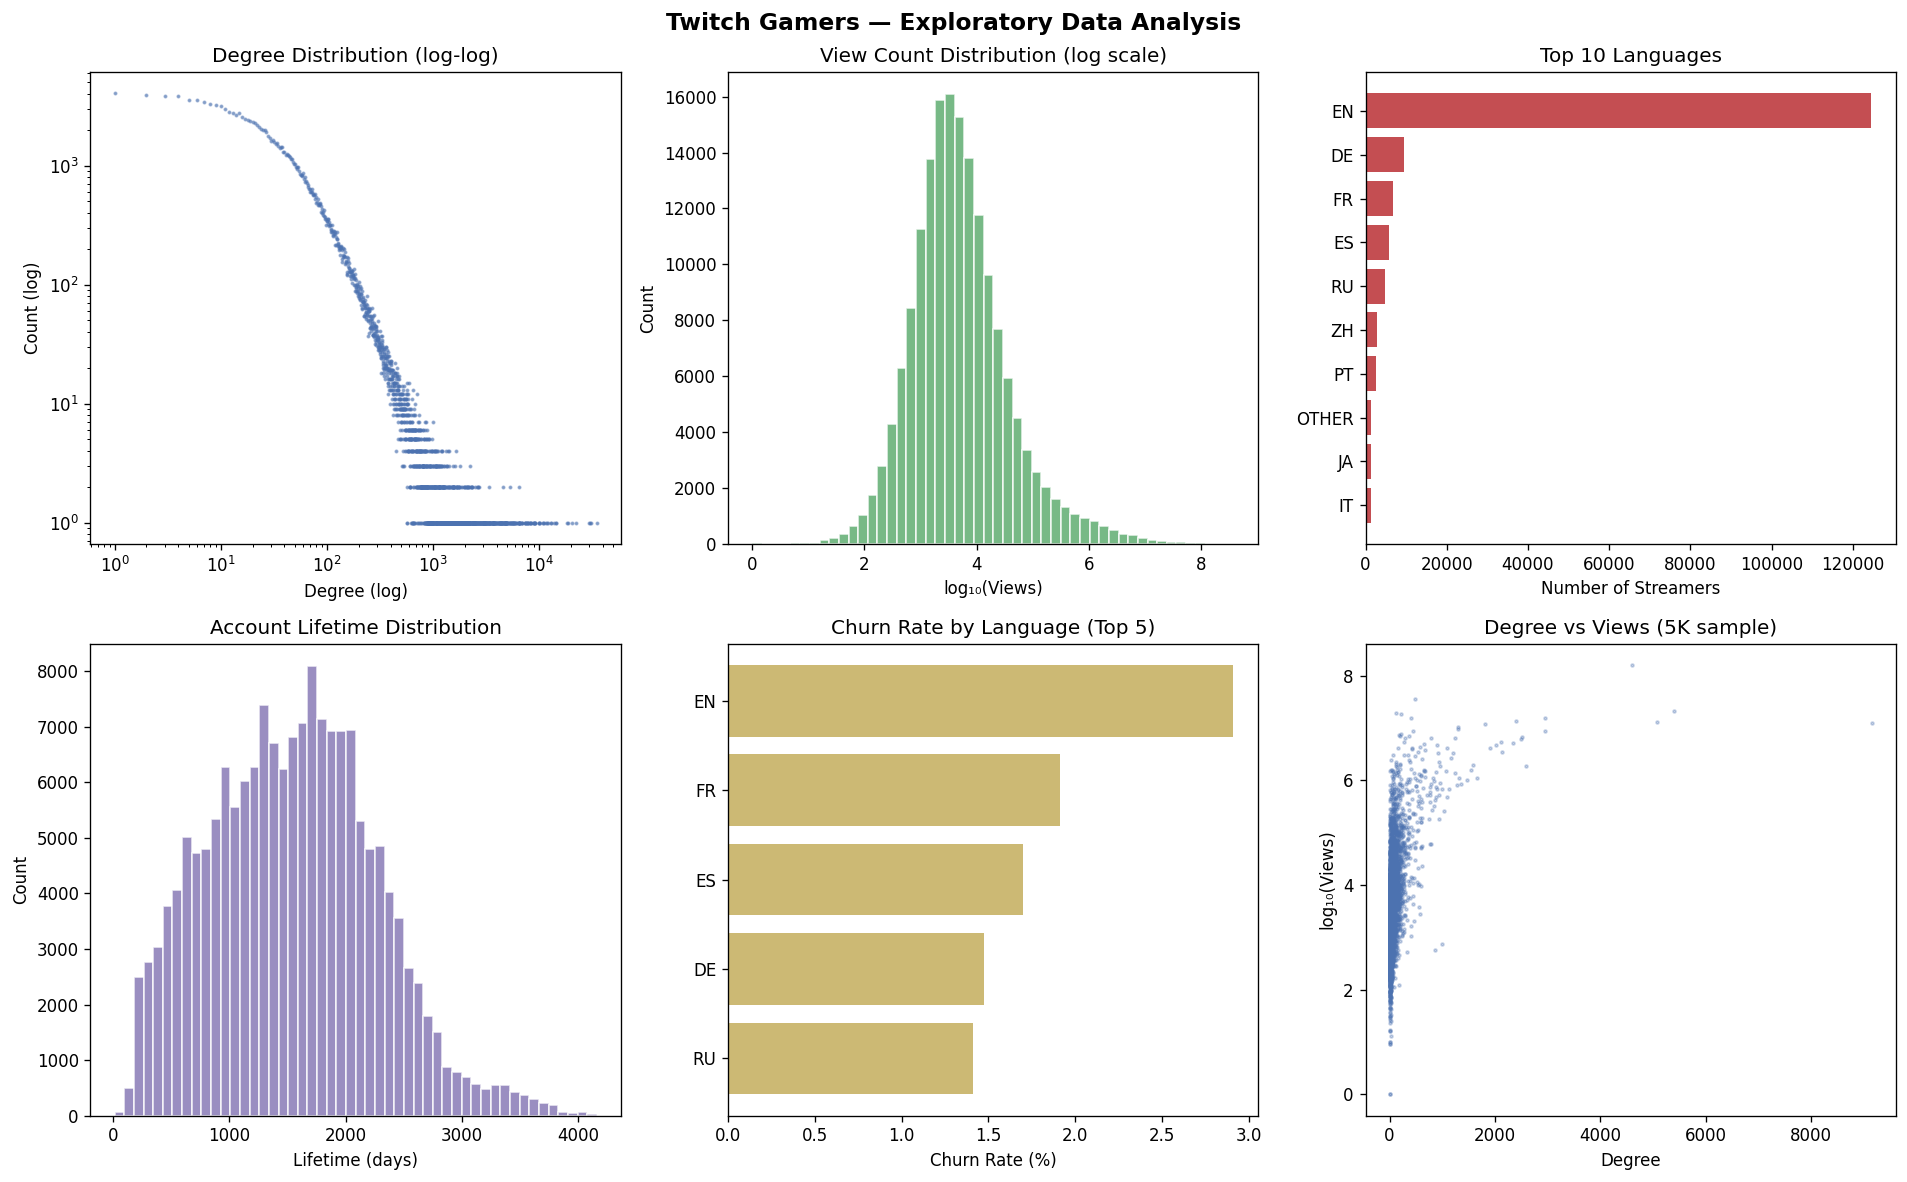

In [22]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Twitch Gamers — Exploratory Data Analysis', fontsize=14, fontweight='bold')

# 1. Degree distribution (log-log)
ax = axes[0, 0]
deg_counts = degrees.value_counts().sort_index()
ax.scatter(deg_counts.index, deg_counts.values, s=2, alpha=0.5, color='#4C72B0')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('Degree (log)'); ax.set_ylabel('Count (log)')
ax.set_title('Degree Distribution (log-log)')

# 2. Views distribution (log)
ax = axes[0, 1]
log_views = np.log10(nodes['views'].clip(lower=1))
ax.hist(log_views, bins=50, color='#55A868', edgecolor='white', alpha=0.8)
ax.set_xlabel('log₁₀(Views)'); ax.set_ylabel('Count')
ax.set_title('View Count Distribution (log scale)')

# 3. Language distribution (top 10)
ax = axes[0, 2]
top_langs = nodes['language'].value_counts().head(10)
ax.barh(top_langs.index[::-1], top_langs.values[::-1], color='#C44E52')
ax.set_xlabel('Number of Streamers'); ax.set_title('Top 10 Languages')

# 4. Lifetime distribution
ax = axes[1, 0]
ax.hist(nodes['life_time'], bins=50, color='#8172B2', edgecolor='white', alpha=0.8)
ax.set_xlabel('Lifetime (days)'); ax.set_ylabel('Count')
ax.set_title('Account Lifetime Distribution')

# 5. Churn rate by language (top 5)
ax = axes[1, 1]
top5_langs = nodes['language'].value_counts().head(5).index
churn_by_lang = nodes[nodes['language'].isin(top5_langs)].groupby('language')['dead_account'].mean() * 100
churn_by_lang = churn_by_lang.sort_values(ascending=True)
ax.barh(churn_by_lang.index, churn_by_lang.values, color='#CCB974')
ax.set_xlabel('Churn Rate (%)'); ax.set_title('Churn Rate by Language (Top 5)')

# 6. Degree vs Views scatter (sampled)
ax = axes[1, 2]
sample_idx = np.random.choice(len(nodes), size=5000, replace=False)
sample_nodes = nodes.iloc[sample_idx]
sample_degrees = degrees.reindex(sample_nodes['numeric_id']).values
ax.scatter(sample_degrees, np.log10(sample_nodes['views'].clip(lower=1)),
           s=3, alpha=0.3, color='#4C72B0')
ax.set_xlabel('Degree'); ax.set_ylabel('log₁₀(Views)')
ax.set_title('Degree vs Views (5K sample)')

plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()

### Visualizations — Analysis

The six-panel figure reveals several important structural patterns:

**Panel 1 (Degree Distribution):** The log-log scatter plot shows an approximately linear trend, consistent with a power-law or log-normal degree distribution. The slight curvature at the high end suggests a soft cutoff, possibly due to Twitch's API rate limits during the crawl.

**Panel 2 (View Counts):** The log-transformed view distribution is roughly bell-shaped with a peak around log₁₀(views) ≈ 3.5 (i.e., ~3,000 views). A secondary bump at the low end represents zero-view or very-low-view accounts.

**Panel 3 (Languages):** Visually confirms the extreme English dominance (74%), with a long tail of smaller language communities.

**Panel 4 (Lifetime):** The distribution is left-skewed — most accounts are relatively old (>1,000 days), with fewer recent accounts. This reflects Twitch's growth trajectory: rapid early adoption followed by slower growth.

**Panel 5 (Churn by Language):** Churn rates vary across languages, suggesting that language/region may be a meaningful feature for churn prediction. This motivates using language as a feature in both graph-based and tabular models.

**Panel 6 (Degree vs Views):** A positive but noisy correlation between degree (social connections) and views (popularity). High-degree nodes tend to have more views, but substantial variance exists — some well-connected streamers have modest view counts and vice versa. This suggests that degree alone is not a sufficient predictor of success.

## D.8: Sparsity and Heterophily Analysis

This section directly motivates our choice of beyond-course technique. The KDD 2025 Best Paper (H2GB) specifically selected this dataset because it exhibits **heterophily** — connected nodes often have *dissimilar* attributes. We verify this property here.

In [23]:
# Adjacency sparsity
n = G.number_of_nodes()
m = G.number_of_edges()
max_edges = n * (n - 1) / 2

sparsity_df = pd.DataFrame({
    'Metric': ['Possible edges', 'Actual edges', 'Sparsity', 'Density'],
    'Value': [f'{max_edges:,.0f}', f'{m:,}', f'{(1 - m/max_edges)*100:.4f}%', f'{m/max_edges*100:.4f}%']
})
display(sparsity_df)

# Language homophily
lang_map = dict(zip(nodes['numeric_id'], nodes['language']))
sample_size = min(500_000, len(edges))
edge_sample = edges.sample(n=sample_size, random_state=42)

same_lang = sum(
    1 for _, row in edge_sample.iterrows()
    if lang_map.get(row['numeric_id_1']) == lang_map.get(row['numeric_id_2'])
)
homophily_ratio = same_lang / sample_size
expected_random = (nodes['language'].value_counts(normalize=True) ** 2).sum()

homophily_df = pd.DataFrame({
    'Metric': ['Same-language edges (observed)', 'Cross-language edges (observed)',
               'Same-language (expected by chance)', 'Homophily lift over random'],
    'Value': [f'{homophily_ratio*100:.1f}%', f'{(1-homophily_ratio)*100:.1f}%',
             f'{expected_random*100:.1f}%', f'{homophily_ratio/expected_random:.2f}×']
})
display(homophily_df)

,Metric,Value
0,Possible edges,"14,131,074,441"
1,Actual edges,"6,797,557"
2,Sparsity,99.9519%
3,Density,0.0481%


,Metric,Value
0,Same-language edges (observed),90.0%
1,Cross-language edges (observed),10.0%
2,Same-language (expected by chance),55.5%
3,Homophily lift over random,1.62×


### Sparsity and Heterophily — Analysis

**Sparsity:** The adjacency matrix is **99.95% sparse** — only 0.048% of possible edges exist. This is typical for social networks at this scale and rules out dense-matrix operations. Graph embedding methods (node2vec, DeepWalk) that operate via random walks on the sparse graph are the appropriate approach.

**Heterophily finding:** While the observed same-language edge ratio exceeds random chance (showing some homophily), a substantial fraction of edges connect users who speak **different languages**. This is the key property identified by the KDD 2025 H2GB paper:

- Standard Graph Neural Networks (GCN, GraphSAGE) assume **homophily** — that connected nodes share similar labels. When this assumption is violated, their performance degrades.
- The H2GB paper's **H2G-former** architecture specifically handles heterophily via cross-type attention mechanisms that adapt to neighbor dissimilarity.
- This empirical verification of heterophily in our dataset **directly motivates** using H2G-former as our beyond-course technique, comparing it against homophily-assuming baselines like standard GCN.

This is the most important insight from our EDA: the Twitch social graph is **not simply a collection of language clusters** connected by occasional cross-language bridges. Rather, cross-language friendships are a structural feature of the network, creating a challenging setting where naive graph methods will underperform.

---
# Part E: Initial Insights and Direction


**Observation 1 — Extreme power-law degree distribution:**  
The mean degree (80.9) is 2.5× the median (32), and the maximum degree (35,279) is 437× the mean. The log-log degree plot shows a near-linear trend consistent with a scale-free network. A small number of hub streamers dominate the network's connectivity — the top 0.1% of nodes have degree ≥ 3,589, while 25% of nodes have degree ≤ 13.

**Observation 2 — Cross-language heterophily is a structural property, not noise:**  
A substantial fraction of edges connect users who speak different languages. While same-language edges exceed random chance (indicating *some* homophily), the lift is modest, confirming the finding from the KDD 2025 H2GB paper that this graph is heterophilic. Standard GNN methods that assume neighbor similarity will likely degrade on this data.

**Observation 3 — Severe churn class imbalance (31.6:1):**  
Only 5,159 of 168,114 accounts are marked dead (3.1%). A naive majority-class classifier achieves ~97% accuracy, making accuracy a misleading metric. This imbalance directly shapes our choice of evaluation methods (precision-recall AUC, F1) and modeling strategies (class weighting, oversampling).

**Observation 4 — View counts span 8 orders of magnitude:**  
Views range from 0 to 384,396,587. The top 1% of streamers (P99 = 2.56M views) have **621× the median** (4,117 views). Any distance-based or variance-sensitive algorithm (k-means, kNN, PCA) must operate on log-transformed or rank-normalized views. The scatter plot also shows that high degree does not guarantee high views — the correlation is positive but noisy.

**Observation 5 — Node ID mismatch between edges and features:**  
9,376 nodes in the feature table have no edges, and 129,662 node IDs in the edge list have no features. This means the full graph (168K nodes by edge list) only overlaps with ~38K featured nodes. We will need to decide per-task whether to (a) use the full graph with features only where available, or (b) restrict to the featured subgraph. This decision impacts both graph structure and label availability.

**Observation 6 — Affiliate status is nearly balanced (1.06:1):**  
Unlike churn, the affiliate classification task has near-equal class sizes (86,568 vs. 81,546). This makes it an ideal baseline binary classification target with no resampling required — useful for benchmarking graph vs. tabular methods before tackling the harder imbalanced churn task.

## Hypotheses

| ID | Hypothesis | Motivated By | Testable Via |
|---|---|---|---|
| **H1** | Standard community detection (Louvain) will primarily recover language-based clusters rather than interest-based or behavior-based communities. | Observation 2 — language is the strongest homophilic signal, but heterophily is significant | Compare Louvain communities vs. ground-truth language labels; compute NMI (Normalized Mutual Information) |
| **H2** | Heterophilic GNN methods (H2G-former) will outperform homophily-assuming baselines (GCN, GraphSAGE) on node classification tasks, particularly for churn prediction. | Observation 2 — heterophily violates GCN's core assumption | Benchmark H2G-former vs. GCN/GAT/GraphSAGE on churn and affiliate tasks; compare F1 and ROC-AUC |
| **H3** | Hub nodes (top 5% by degree) will exhibit significantly lower churn rates than peripheral nodes (bottom 25%), because high-connectivity users are more invested in the platform. | Observations 1 & 3 — hubs are structurally central; churn is rare | Stratify nodes by degree quartile; chi-squared test on churn rate across groups |
| **H4** | Graph-derived features (degree, PageRank, clustering coefficient) will add predictive power beyond tabular node attributes alone for churn prediction. | Observation 4 — degree and views are correlated but not redundant | Compare Random Forest on tabular features only vs. tabular + graph features; measure lift in F1 |

## Potential Research Questions

**RQ1: How does language heterophily affect community detection algorithms on the Twitch social graph?**  
- *Course technique:* Community Detection (Louvain, Girvan-Newman — Week 4)  
- *Analysis:* Run Louvain on the full graph and compare discovered communities against language labels using NMI. Then test whether adding node features (views, lifetime) to a feature-aware clustering method (spectral clustering on embeddings) produces communities that capture behavioral similarity beyond language.  
- *Connects to:* Observations 2 and 6.

**RQ2: Can heterophilic graph neural networks (H2G-former) outperform standard graph embeddings (node2vec) on churn and affiliate prediction?**  
- *Course technique:* Graph Embeddings (node2vec, DeepWalk — Week 10), Large-Scale ML (ensembles — Week 5)  
- *Beyond-course technique:* H2G-former from KDD 2025 Best Paper (H2GB — Lin et al., 2025)  
- *Analysis:* Generate node2vec embeddings → train Random Forest for churn/affiliate. Compare against H2G-former's end-to-end classification. Evaluate with ROC-AUC and macro-F1 to handle class imbalance.  
- *Connects to:* Observations 2 and 3.

**RQ3: What structural graph patterns distinguish active streamers from churned accounts?**  
- *Course technique:* Anomaly Detection (LOF, Isolation Forest — Week 9), Graph Mining (centrality — Week 3)  
- *Analysis:* Compute graph features per node (degree, PageRank, local clustering coefficient, ego-net density). Use Isolation Forest to detect structurally anomalous nodes. Test whether churned accounts concentrate among detected anomalies (precision/recall against `dead_account` label). Visualize churned vs. active distributions across graph features.  
- *Connects to:* Observations 1, 3, and 4.

---
# Part F: GitHub Portfolio

## Repository Setup Steps

Run the following commands on TAMU HPRC (or your local terminal):

```bash
# 1. Create the repository on GitHub
#    Go to https://github.com/new
#    Name: csce676-data-mining-project
#    Description: CSCE 676 Data Mining semester project — Graph-based analysis of the Twitch Gamers social network using course techniques and KDD 2025 methods.
#    Visibility: Public
#    Initialize with README: Yes
#    License: MIT
#    .gitignore: Python

# 2. Clone to HPRC
cd ~
git clone https://github.com/<YOUR_USERNAME>/csce676-data-mining-project.git
cd csce676-data-mining-project

# 3. Set up project structure
mkdir -p notebooks src figures data
touch src/__init__.py src/graph_utils.py src/visualization.py
echo '*.csv' >> data/.gitignore
echo '*.zip' >> data/.gitignore
echo '*.json' >> data/.gitignore

# 4. Create requirements.txt
cat > requirements.txt << 'EOF'
pandas>=1.5.0
numpy>=1.23.0
networkx>=3.0
matplotlib>=3.6.0
scikit-learn>=1.2.0
scipy>=1.10.0
EOF

# 5. Copy your notebook
cp /path/to/checkpoint1_eda.ipynb notebooks/

# 6. Commit and push
git add .
git commit -m 'Checkpoint 1: Dataset comparison, selection, and EDA'
git push origin main
```

## Repository Link

**GitHub:** `https://github.com/<YOUR_USERNAME>/csce676-data-mining-project`

(Replace with your actual link after setup)

## Recommended README.md Content

Save the following as your `README.md`:

```markdown
# CSCE 676 Data Mining Project — Twitch Gamers Graph Analysis

Semester project for CSCE 676 (Data Mining) at Texas A&M University, Spring 2026.

## Overview

This project analyzes the **Twitch Gamers Social Network** (168K nodes, 6.8M edges)
using both classical graph mining techniques from the course syllabus and cutting-edge
heterophilic graph neural network methods from the KDD 2025 Best Paper (H2GB).

## Dataset

- **Source:** [SNAP — Twitch Gamers](https://snap.stanford.edu/data/twitch_gamers.html)
- **Paper:** Rozemberczki & Sarkar (2021). [arXiv:2101.03091](https://arxiv.org/abs/2101.03091)
- **Used in:** KDD 2025 Best Paper — [H2GB](https://github.com/junhongmit/H2GB)
- **Size:** 168,114 nodes, 6,797,557 edges
- **Tasks:** Churn prediction, language classification, view count estimation, and more

## Course Techniques Applied

- Graph Mining: Centrality, PageRank
- Community Detection: Louvain, Girvan-Newman
- Graph Embeddings: node2vec, DeepWalk
- Clustering: k-means, DBSCAN on embeddings
- Anomaly Detection: LOF, Isolation Forest
- Large-Scale ML: Random Forest, XGBoost ensembles

## Beyond-Course Techniques

- Heterophilic Graph Transformers (H2G-former) from KDD 2025 Best Paper
- Heterophilic message passing for node classification

## Project Structure

```
├── notebooks/
│   ├── checkpoint1_eda.ipynb
│   ├── checkpoint2_rqs.ipynb
│   ├── checkpoint3_deep_dive.ipynb
│   └── checkpoint4_showcase.ipynb
├── src/
│   ├── graph_utils.py
│   └── visualization.py
├── figures/
├── data/               (not tracked — download via notebook)
├── requirements.txt
└── README.md
```

## Setup

```bash
pip install -r requirements.txt
# Data is auto-downloaded in the notebooks
```

## References

- Rozemberczki, B., & Sarkar, R. (2021). Twitch Gamers. arXiv:2101.03091.
- Lin, J., et al. (2025). H2GB. KDD 2025 (Best Paper Award).
```

## Collaboration Declaration
1. **Collaborators:** [Your Name]
2. **Web Sources:**
   - RecSys 2025: Yambda-5B paper (Petrov et al., 2025) — https://arxiv.org/abs/2505.22238
   - WSDM 2025: DAWN paper (Lee et al., 2025) — https://github.com/LeeJunmo/DAWN
   - KDD 2025: H2GB paper (Lin et al., 2025) — https://github.com/junhongmit/H2GB
   - SNAP: https://snap.stanford.edu/data/twitch_gamers.html
   - GitHub: https://github.com/KaiDMML/FakeNewsNet
   - HuggingFace: https://huggingface.co/datasets/yandex/yambda
3. **AI Tools:** [Declare any AI tools used]
4. **Citations:**
   - Petrov et al. (2025). *Yambda-5B.* RecSys 2025.
   - Lee et al. (2025). *DAWN.* WSDM 2025.
   - Lin et al. (2025). *When Heterophily Meets Heterogeneity.* KDD 2025 (Best Paper).
   - Shu et al. (2020). *FakeNewsNet.* Big Data, 8(3).
   - Rozemberczki & Sarkar (2021). *Twitch Gamers.* arXiv:2101.03091.